# 利用MindQuantum解决组合优化问题

In [9]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html


In [10]:
import networkx as nx

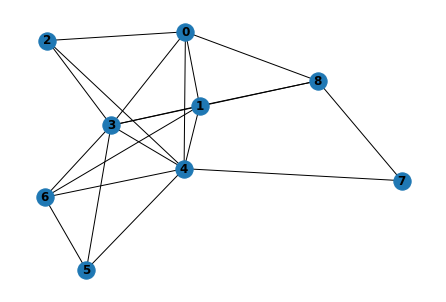

In [11]:
g = nx.gnm_random_graph(9, 20, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [14]:
print(list(g.edges))

[(0, 1), (0, 8), (0, 2), (0, 4), (0, 3), (1, 8), (1, 6), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (3, 8), (3, 6), (3, 5), (4, 7), (4, 5), (4, 6), (5, 6), (7, 8)]


## nx库中的解法

In [15]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

14 ({8, 3, 4}, {0, 1, 2, 5, 6, 7})


## Try to solve by yourself

In [16]:
def solution(edges):
    pass

In [17]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get None cuts


## QAOA

In [18]:
from mindquantum import *

In [19]:
depth = 3
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

q0: ──H────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)─────────────────────────────────────────────────────────────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)─────────────────────────────────────────────────────────────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │             │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │
q1: ──H────ZZ(beta_0)────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │             │             │                                                                                                                                                                             │             │             │             │              │             │             │             │
q2: ──H──────────────────────┼─────────ZZ(beta_0)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────ZZ(beta_1)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────ZZ(beta_2)────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┼──────────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │                           │             │              │             │             │             │              │             │                  

In [20]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [21]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-9.88340089-9.22433419e-19j]]),
 array([[[-2.14993018+0.j,  0.05567376+0.j,  0.18139994+0.j,
           0.21913753+0.j, -0.00672905+0.j,  0.13963079+0.j]]]))

### 利用`scipy`的优化器进行优化

In [23]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    if((-f.real[0, 0])>13):
        print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

np.random.seed(1)
x0 = np.random.random(len(circuit.params_name))
optimizers = ['cg', 'COBYLA', 'Powell', 'bfgs','Nelder-Mead','Newton-CG']
# opti = optimizers[-1]
# tol = 1e-3

tols = [1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
for opti in ['Powell']:
    print(opti)
    for tol in tols:
        print("tol = %f" %tol)
        res = minimize(fun, x0, method=opti, jac=True, tol=tol)
        print("这是分割线")

Powell
tol = 1.000000
这是分割线
tol = 0.100000
这是分割线
tol = 0.010000
Cut value: 13.04417116610703
Cut value: 13.04417116610703
Cut value: 13.062339860323101
Cut value: 13.038226864057094
Cut value: 13.062339860323101
Cut value: 13.062339860323101
Cut value: 13.106470540996595
Cut value: 13.106470540996595
Cut value: 13.106470540996595
Cut value: 13.113962208497114
Cut value: 13.10819437589481
Cut value: 13.113962208497114
Cut value: 13.113962208497114
Cut value: 13.153690319966762
Cut value: 13.084260518085092
Cut value: 13.153690319966762
Cut value: 13.153690319966762
Cut value: 13.162536393712564
Cut value: 13.151719570050403
Cut value: 13.162536393712564
Cut value: 13.162536393712564
Cut value: 13.161517735390014
Cut value: 13.16644231271425
Cut value: 13.140934686596944
Cut value: 13.164445231269639
Cut value: 13.16644231271425
Cut value: 13.16644231271425
Cut value: 13.17612747131248
Cut value: 13.160667781592913
这是分割线
tol = 0.001000
Cut value: 13.01649196807248
Cut value: 13.021412792

In [ ]:



=def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [ ]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

In [ ]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')
print(f'\nYour configuration:\ndepth: {depth}\nmethod: {opti}\ntol: {tol}\nstep: {res.nfev}')